<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_auxiliary_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple template for the Variational Autoencoder Model (VAE):

https://arxiv.org/pdf/1312.6114.pdf

https://arxiv.org/pdf/1907.04809.pdf (iVAE)

In [1]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [0]:
from sklearn.datasets.samples_generator import make_blobs
N_centers = 5
X, y = make_blobs(n_samples=5000, centers=N_centers, n_features=32,random_state=1)
U = y

In [0]:
def normalize_data(X):
  return (X-np.mean(X,axis=0)/np.std(X,axis=0))

In [0]:
X = normalize_data(X)

In [0]:
#Multivariate diagional
def create_encoder(inpt, latent_size):
  x = inpt
  x = tf.layers.dense(x, 32, tf.nn.relu)
  x = tf.layers.dense(x, 16, tf.nn.relu)
  loc = tf.layers.dense(x,latent_size)
  log_variance = tf.layers.dense(x, latent_size)
  scale = tf.nn.softplus(log_variance)
  return tfd.MultivariateNormalDiag(loc, scale)

def create_prior(latent_size, u):
  act = tf.nn.leaky_relu
  
  h = tf.layers.dense(u, 5, act)
  h = tf.layers.dense(h, 3, act)
  loc = tf.layers.dense(h, latent_size)
  log_variance = tf.layers.dense(h, latent_size)
  scale = tf.nn.softplus(log_variance)
  return tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)

def create_decoder(inpt, output_size):
  x = inpt
  x = tf.layers.dense(x, 16, tf.nn.relu)
  loc = tf.layers.dense(x, output_size)
  scale = tf.ones(output_size)
  return tfd.MultivariateNormalDiag(loc, scale)

In [68]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.int32, shape=[None], name='u_in')
u = tf.one_hot(u_in, N_centers, axis=-1)

print(u_in)
print(x_in)
x = tf.concat((x_in, u), axis=-1)

print(x)
latent_size = 2

latent_prior = create_prior(latent_size, u)
latent_posterior = create_encoder(x, latent_size=latent_size)

latent_sampled = latent_posterior.sample()
latent_mean = latent_posterior.mean()

posterior = create_decoder(latent_sampled, X.shape[1])

posterior_sampled = posterior.sample()
posterior_mean = posterior.mean()

rec_loss = -tf.reduce_mean(posterior.log_prob(x_out))
#kl = tf.reduce_mean(tfd.kl_divergence(latent_posterior, latent_prior)) #analytical
kl = tf.reduce_mean(latent_posterior.log_prob(latent_sampled)- latent_prior.log_prob(latent_sampled)) #approximate KL
beta=1.0
kl_loss = beta*kl


loss = rec_loss + kl_loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

Tensor("u_in:0", shape=(?,), dtype=int32)
Tensor("x_in:0", shape=(?, 32), dtype=float32)
Tensor("concat:0", shape=(?, 37), dtype=float32)


In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part]

In [75]:
n_epochs = 50
batch_size = 25
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    total_loss = 0
    total_rec_loss = 0
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      _, total_loss_, total_rec_loss_ = sess.run([optimizer, loss, rec_loss], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      total_loss += total_loss_
      total_rec_loss += total_rec_loss_
    if (i+1)% 10 == 0 or i == 0:
      latent_mean_, latent_sampled_, posterior_mean_, posterior_sampled_= sess.run([latent_mean, latent_sampled, posterior_mean, posterior_sampled], feed_dict ={x_in:X, x_out:X, u_in:U})
      end = time.time()
      print('epoch: {0}, total_loss: {1:.2f}, rec_loss: {2:.2f}, time: {3:.2f}'.format((i+1), 
                                       total_loss/(1+np.int(X.shape[0]/batch_size)), total_rec_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()

epoch: 1, total_loss: 491.21, rec_loss: 470.90, time: 1.39
epoch: 10, total_loss: 52.46, rec_loss: 45.69, time: 7.09
epoch: 20, total_loss: 51.81, rec_loss: 45.50, time: 7.91
epoch: 30, total_loss: 49.71, rec_loss: 45.35, time: 7.93
epoch: 40, total_loss: 49.40, rec_loss: 45.30, time: 8.26
epoch: 50, total_loss: 48.75, rec_loss: 45.28, time: 7.78


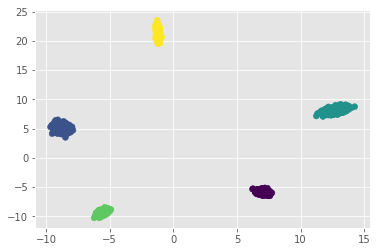

In [71]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=y);

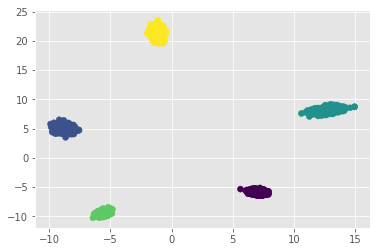

In [72]:
plt.scatter(latent_sampled_[:,0],latent_mean_[:,1], c=y);

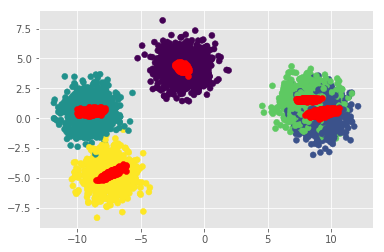

In [73]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_mean_[:,0],posterior_mean_[:,1], c='red');

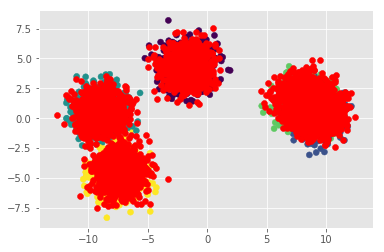

In [74]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_sampled_[:,0],posterior_sampled_[:,1], c='red');